In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [202]:
# Read in the data
df = pd.read_csv('./Data/small_box_office_flat_file.csv', header=0)

# ID isn't needed for analysis
df = df.drop('ID', axis=1)

## Data Preprocessing

Let's convert Dtypes of each column to the right Dtype:

In [203]:
class DtypeTransformer:
    """Converts the columns in col_names to the specified dtype"""
    def __init__(self, df):
        self.df = df

    def transform(self, col_names, dtype):
        self.df[col_names] = self.df[col_names].astype(dtype)
        return self.df
    
    def transform_to_bull(self):
        
        #  Find all numeric columns
        column_names = df.select_dtypes(include=[np.number]).columns 

        # re-extracting the columns of numerical type (using awesome np.number1 :)) then getting the max of those and storing them in a temporary variable m.
        m = df[df.select_dtypes(include=[np.number]).columns].max().reset_index(name='max')
        n = m.loc[m['max']==1, 'max']

        # Extracted the indexes of the rows from n and stored them in temporary variable p.
        # These indexes are the same as the indexes from original dataframe 'df'.
        p = column_names[n.index]
        
        return self.transform(p, 'bool')

# We can use the DtypeTransformer to convert the columns to the correct dtypes
# Sending only features to transform
transformer = DtypeTransformer(df)

# Set boolean values to 'bool' dtype
transformer.transform_to_bull()

# Convert Categorical column to 'category' dtype
cat_column_names = ['OriginLang', 'CatRuntime', 'Genre']
transformer.transform(cat_column_names, 'category')

# Convert 'ReleaseDate' to datetime
transformer.transform('ReleaseDate', 'datetime64[ns]')

# Creating list of columns name by data type
bool_columns = list(df.select_dtypes(include=['bool']).columns)
cat_columns = list(df.select_dtypes(include=['category']).columns)
numeric_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)
target_column = ['Revenue']



## Visualize correlation with a diagonal correlation plot

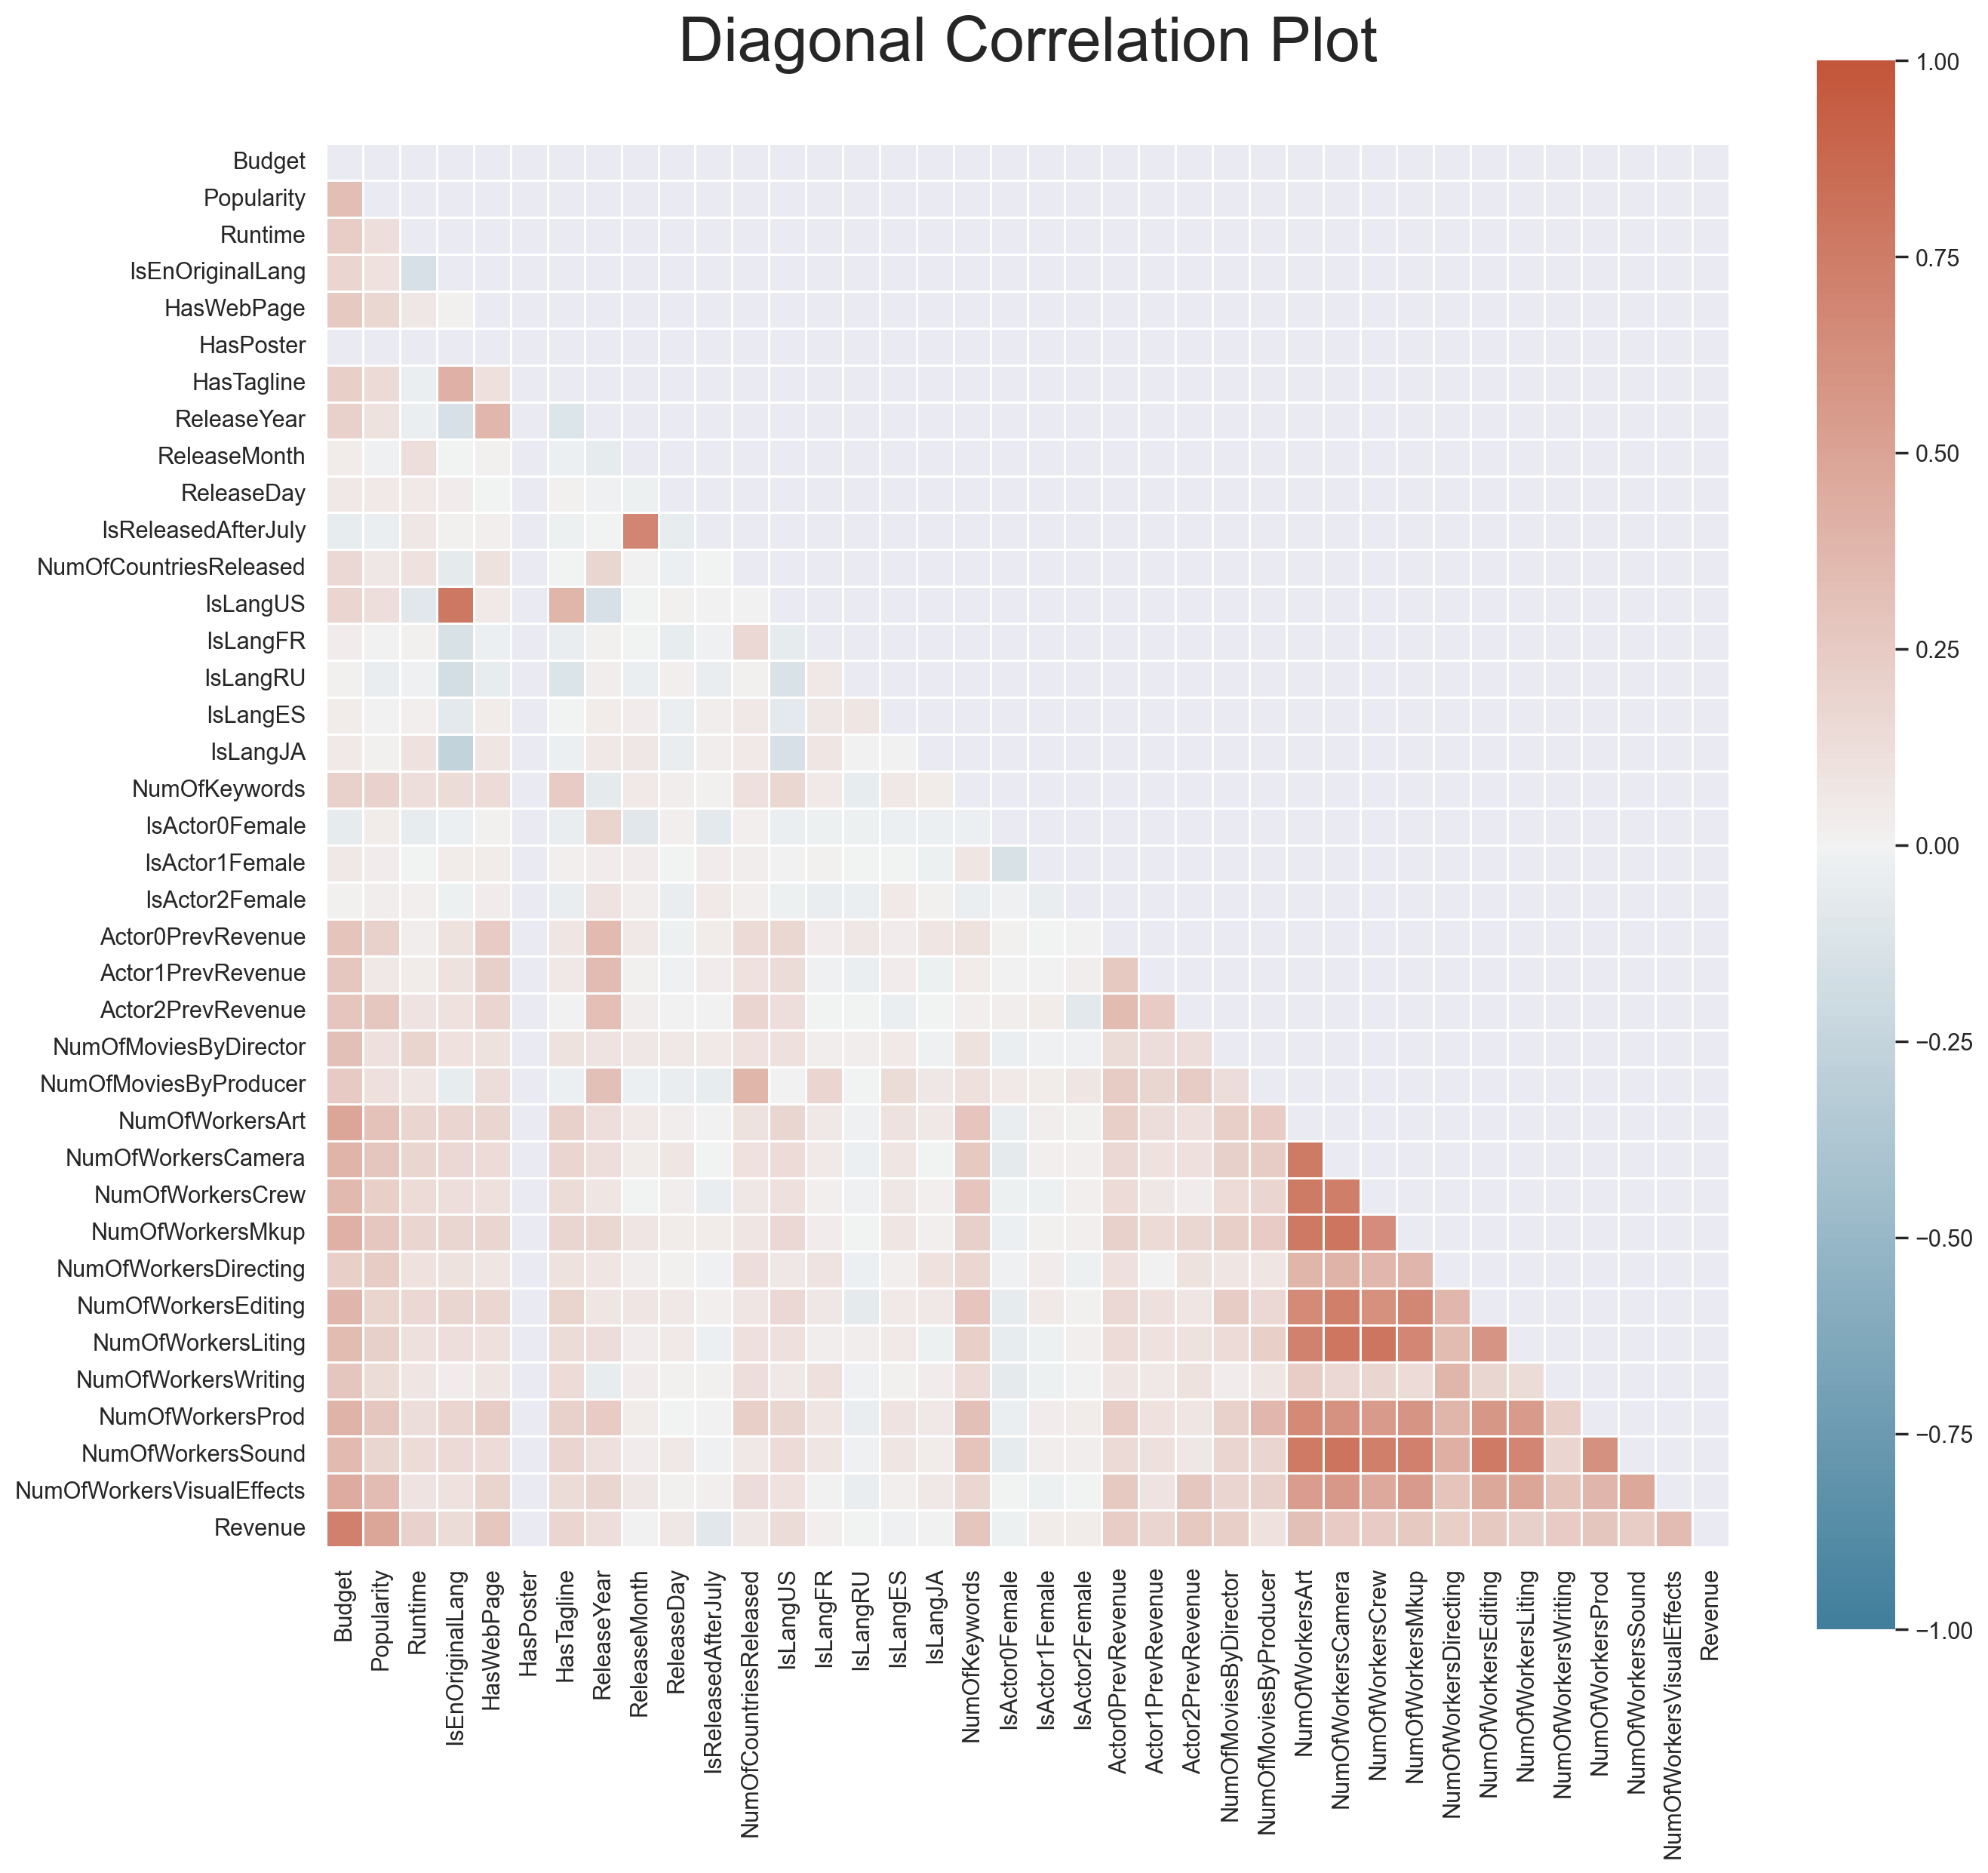

In [204]:
# Compute the correlation matrix with pearson correlation
corr = df.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))                    # Set figure size

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask 
sns.heatmap(corr, 
            mask = mask, 
            cmap = cmap, 
            vmax = 1,                                      # Set scale min value
            vmin = -1,                                     # Set scale min value
            center = 0,                                    # Set scale min value
            square = True,                                 # Ensure perfect squares
            linewidths = 1,                                # Set linewidth between squares
            cbar_kws = {"shrink": .9},                     # Set size of color bar
           );

plt.xticks(rotation=90)                                    # Rotate x labels
plt.yticks()
plt.title('Diagonal Correlation Plot', size=30, y=1.05);   # Set plot title and position

We see there exist a correlation between the sizes of the department crews (nothing spacial)


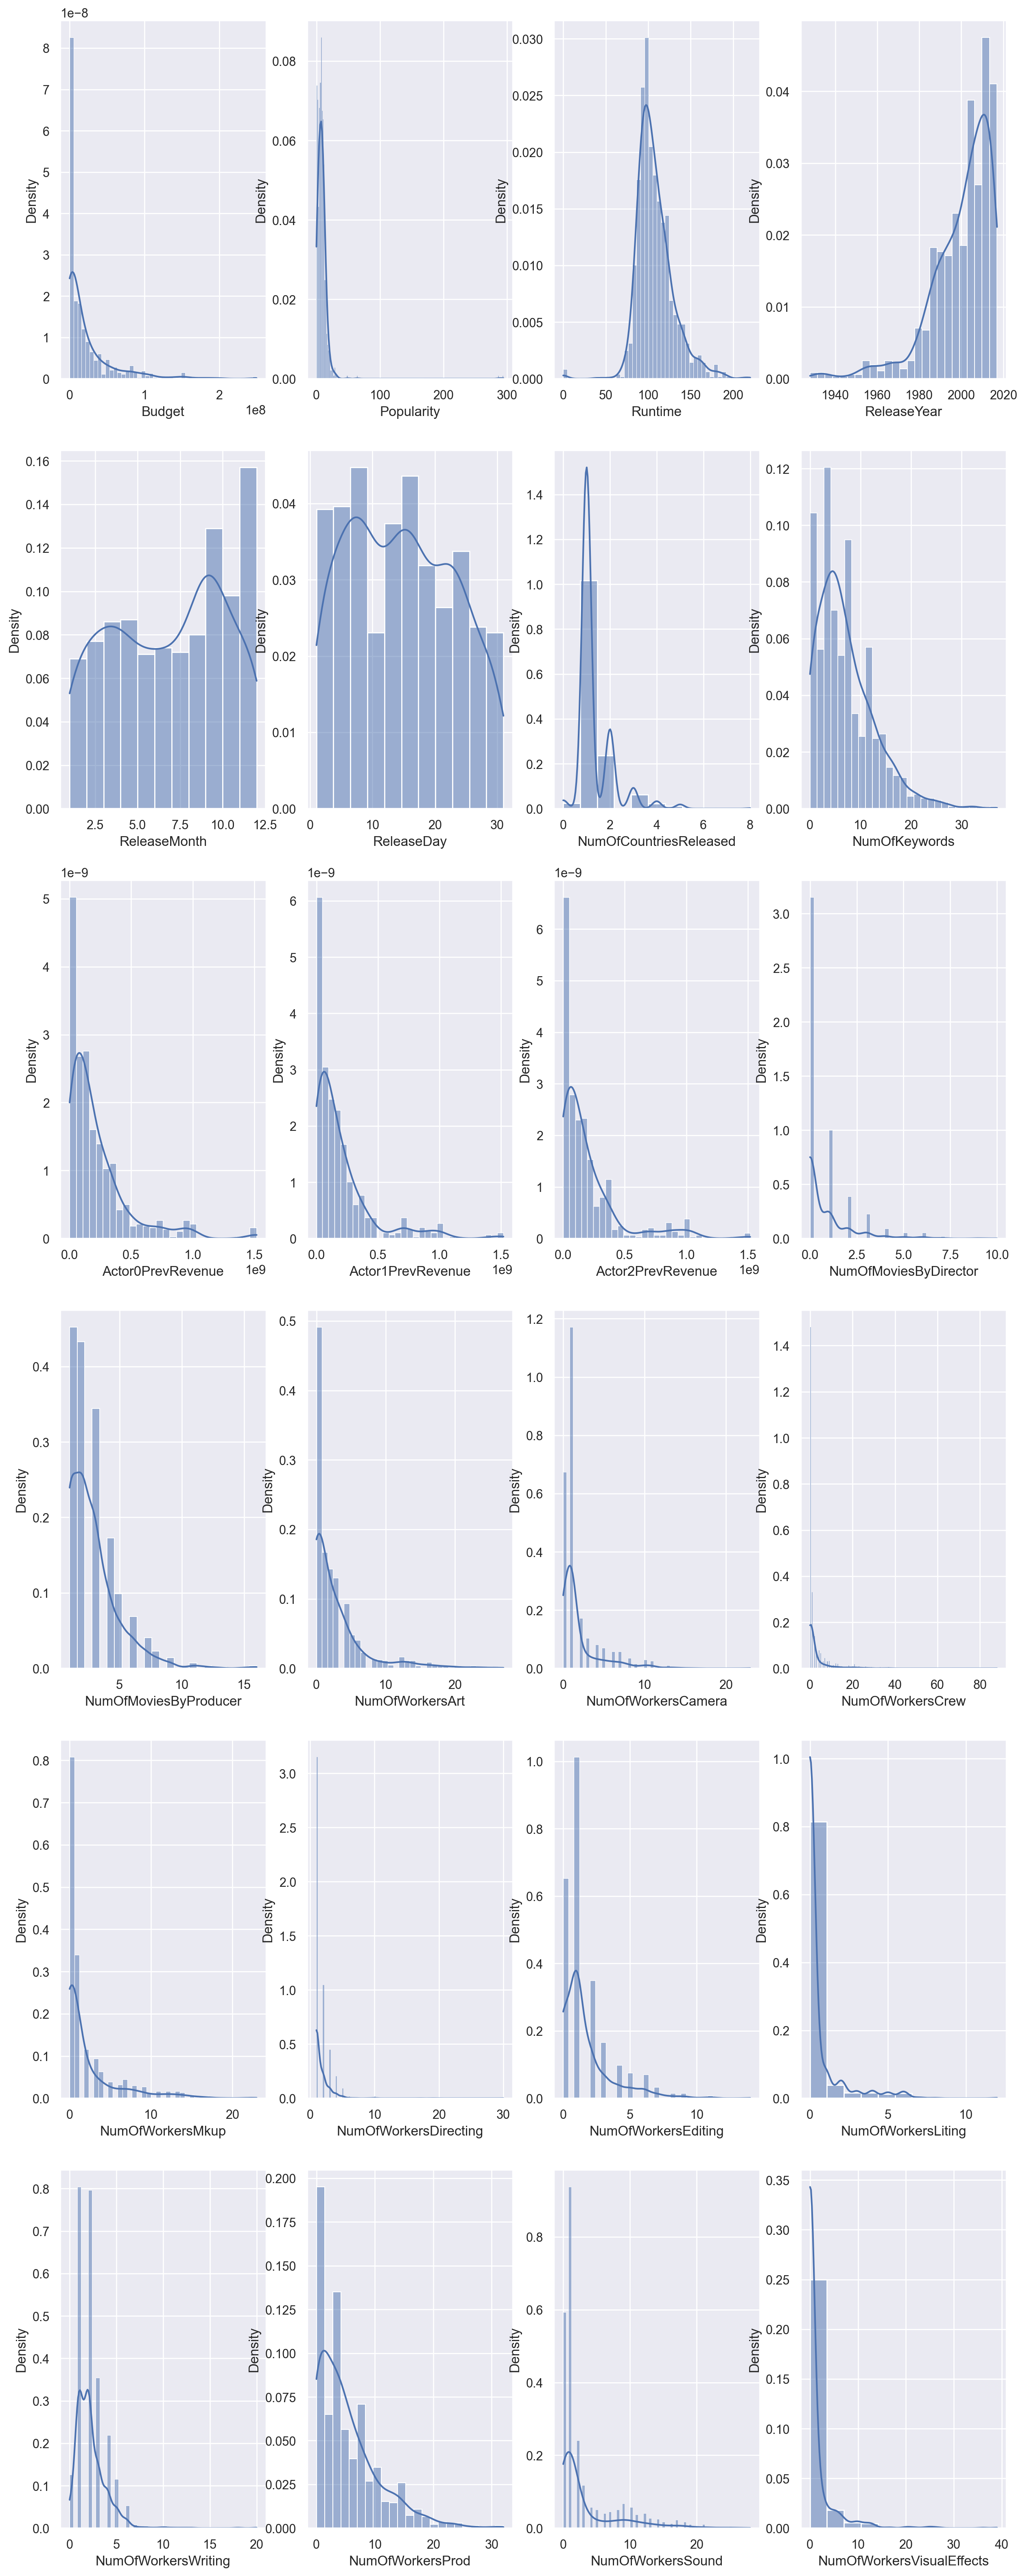

In [205]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 40))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.histplot(data=df[numeric_columns], x=col, ax=axis, kde=True, stat='density')
plt.show()


Let's plot the categorial features in respect to Revenue

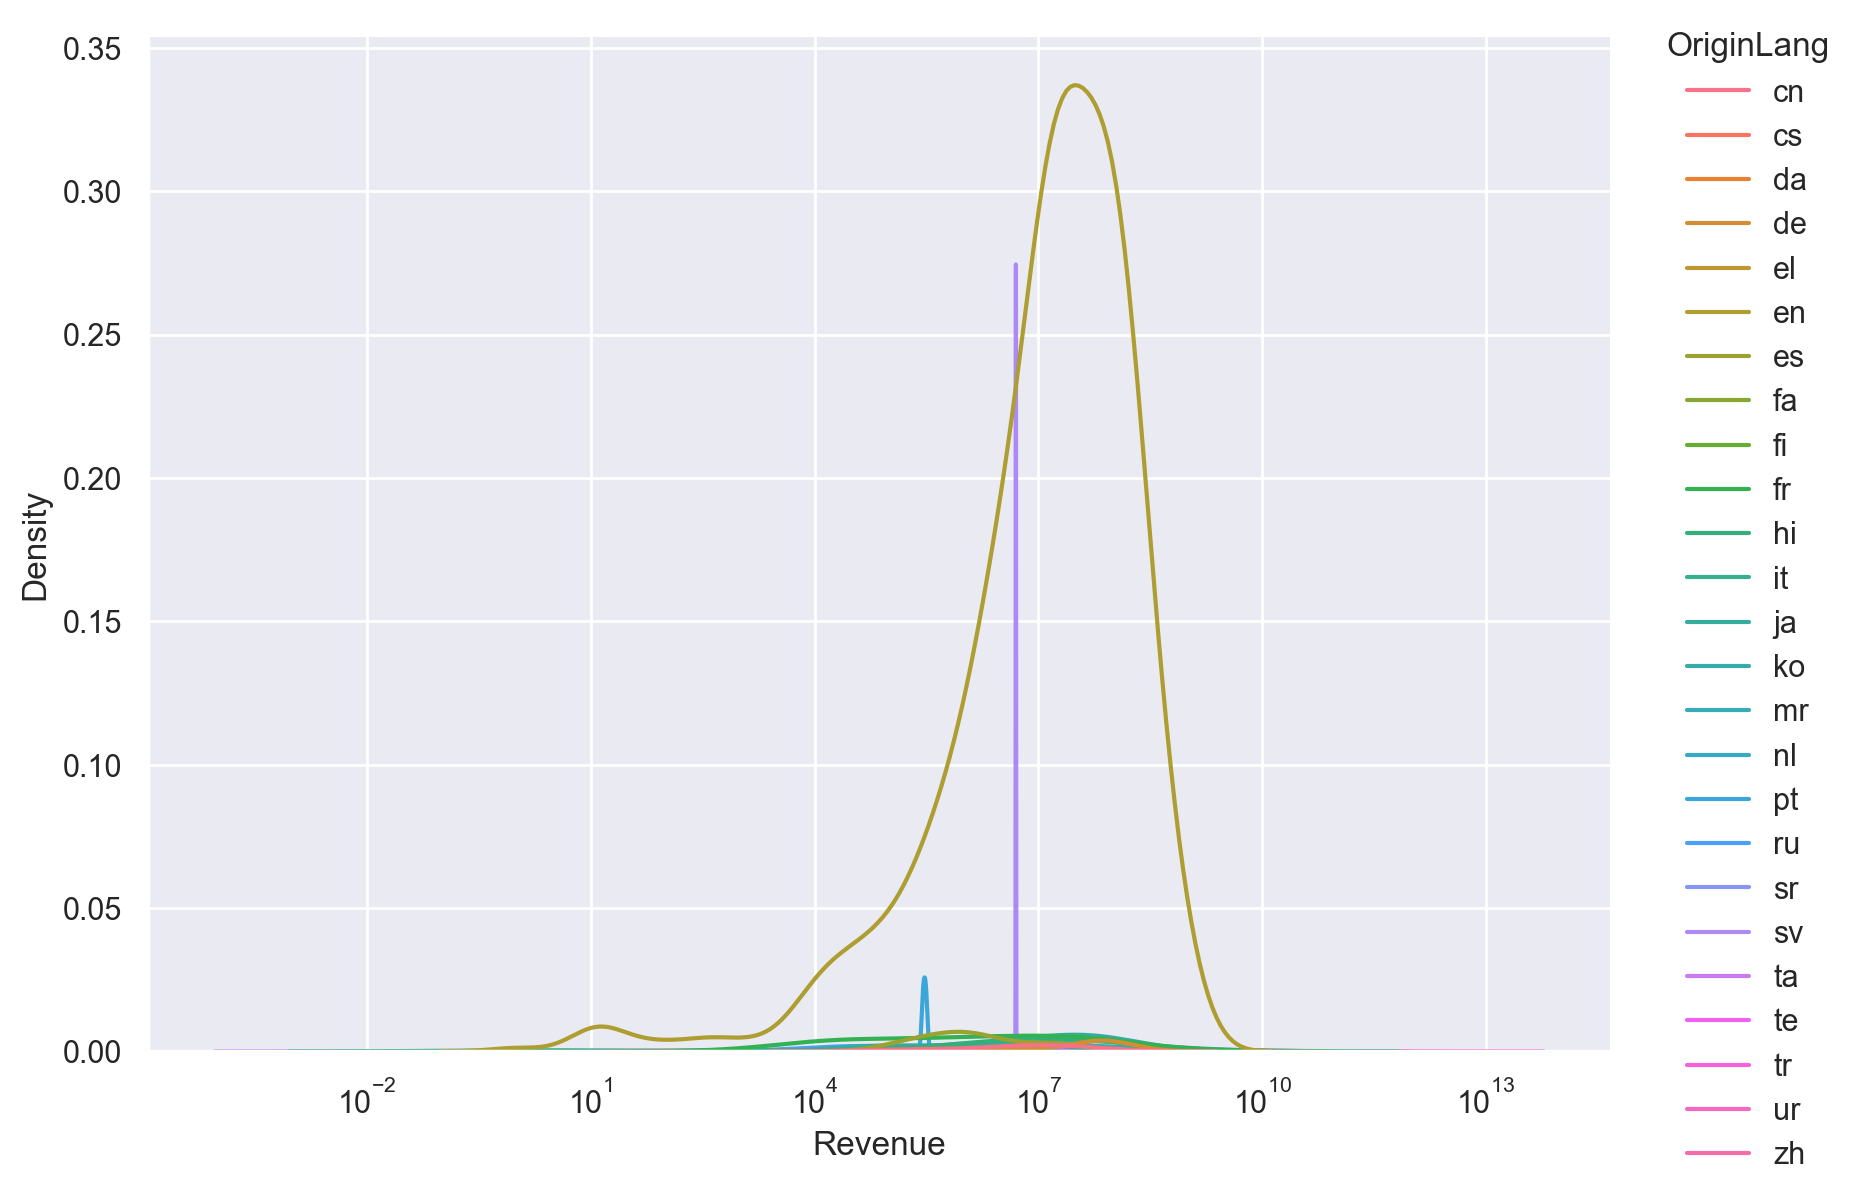

In [206]:
for cat in cat_columns:
    sns.displot(data=df, x="Revenue", hue=cat, kind="kde",
                height=6, aspect=1.4, log_scale=10, warn_singular=False,
                legend=True)
    

## Describe and plot the target variable -
First lets see how the target variable distributed

Just by looking on the data it easy to notice that there are outliers (in features and target variables).

 Later I will deal with them..

In [207]:
# df.drop(df.query("Revenue > (0.4*1e9)").index, inplace=True)
sns.displot(df.Revenue, kind='kde', height=5, aspect=2, log_scale=10)
df.Revenue.describe()

count    1.000000e+03
mean     6.861850e+07
std      1.400552e+08
min      1.000000e+00
25%      2.493500e+06
50%      1.631229e+07
75%      7.220126e+07
max      1.262886e+09
Name: Revenue, dtype: float64

### Explore nullity of the df

We would like to print only columns have null values in df

In [208]:
nullseries = df.isnull().sum()
print(nullseries[nullseries>0])
sns.heatmap(df.isnull(), cbar=False)

Actor0PrevRevenue            299
Actor1PrevRevenue            391
Actor2PrevRevenue            414
NumOfMoviesByProducer         56
NumOfWorkersArt                5
NumOfWorkersCamera             5
NumOfWorkersCrew               5
NumOfWorkersMkup               5
NumOfWorkersDirecting          5
NumOfWorkersEditing            5
NumOfWorkersLiting             5
NumOfWorkersWriting            5
NumOfWorkersProd               5
NumOfWorkersSound              5
NumOfWorkersVisualEffects      5
dtype: int64


<AxesSubplot:>

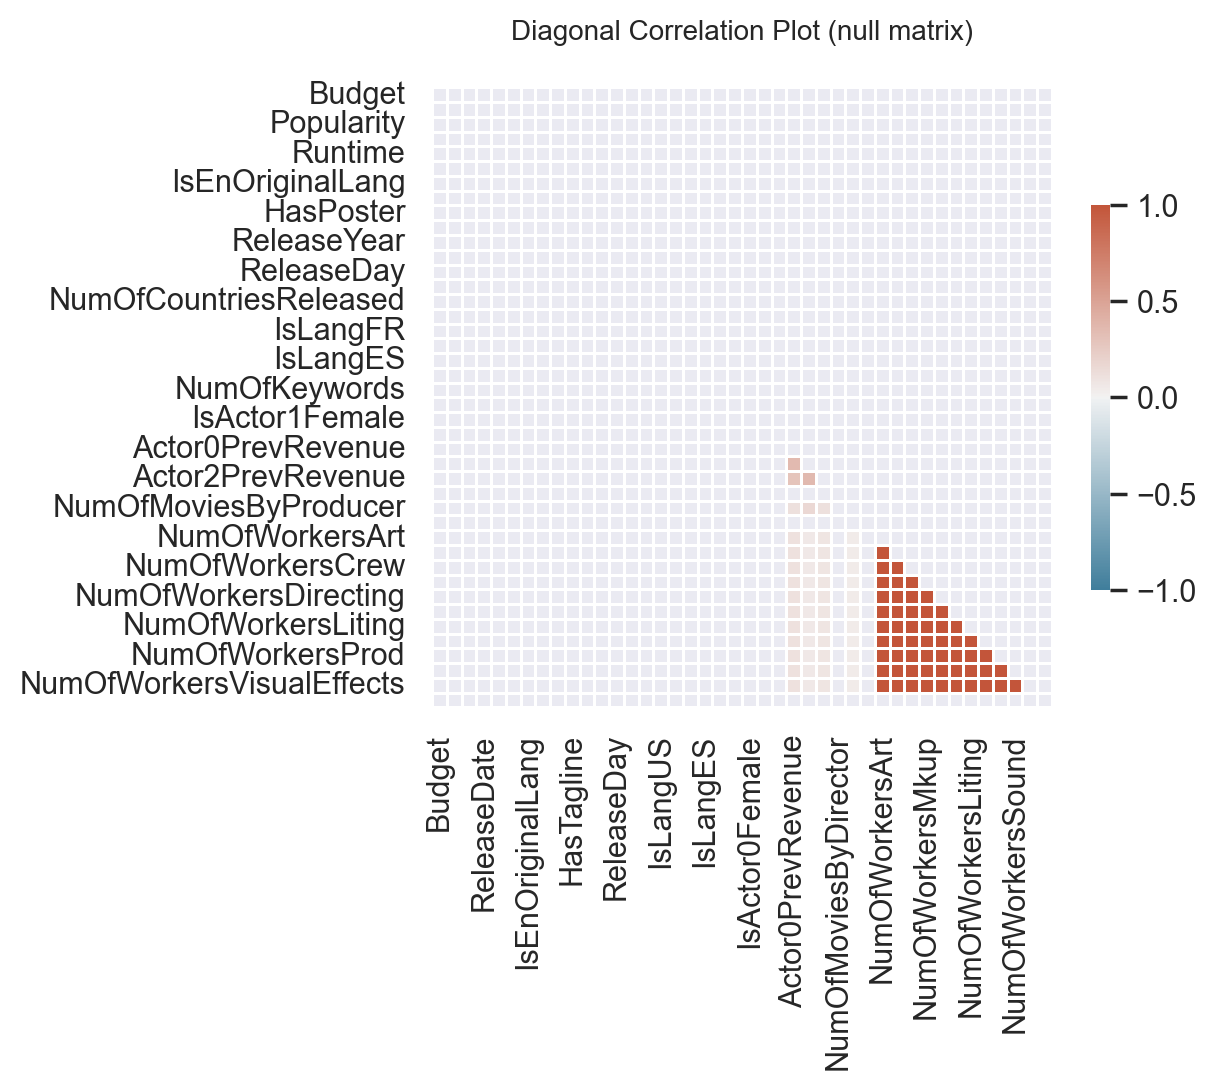

In [209]:
# Compute the correlation matrix of the null df with pearson correlation
null_corr = df.isnull().corr(method = 'pearson')

# Generate a mask for the upper triangle
null_mask = np.triu(np.ones_like(null_corr, dtype=bool))

# Set up the matplotlib figure
null_fig, null_ax = plt.subplots(figsize=(5, 5))                    # Set figure size

# Generate a custom diverging colormap
null_cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask 
sns.heatmap(null_corr, 
            mask = null_mask, 
            cmap = null_cmap, 
            vmax = 1,                                      # Set scale min value
            vmin = -1,                                     # Set scale min value
            center = 0,                                    # Set scale min value
            square = True,                                 # Ensure perfect squares
            linewidths = .5,                               # Set linewidth between squares
            cbar_kws = {"shrink": .5},                     # Set size of color bar
           );

plt.xticks(rotation=90)                                    # Rotate x labels
plt.yticks()
plt.title('Diagonal Correlation Plot (null matrix)', size=10, y=1.05);   # Set plot title and position

### OutLiers 
First, lets use BoxPlot to visualize the outliers then remove them using IQR score

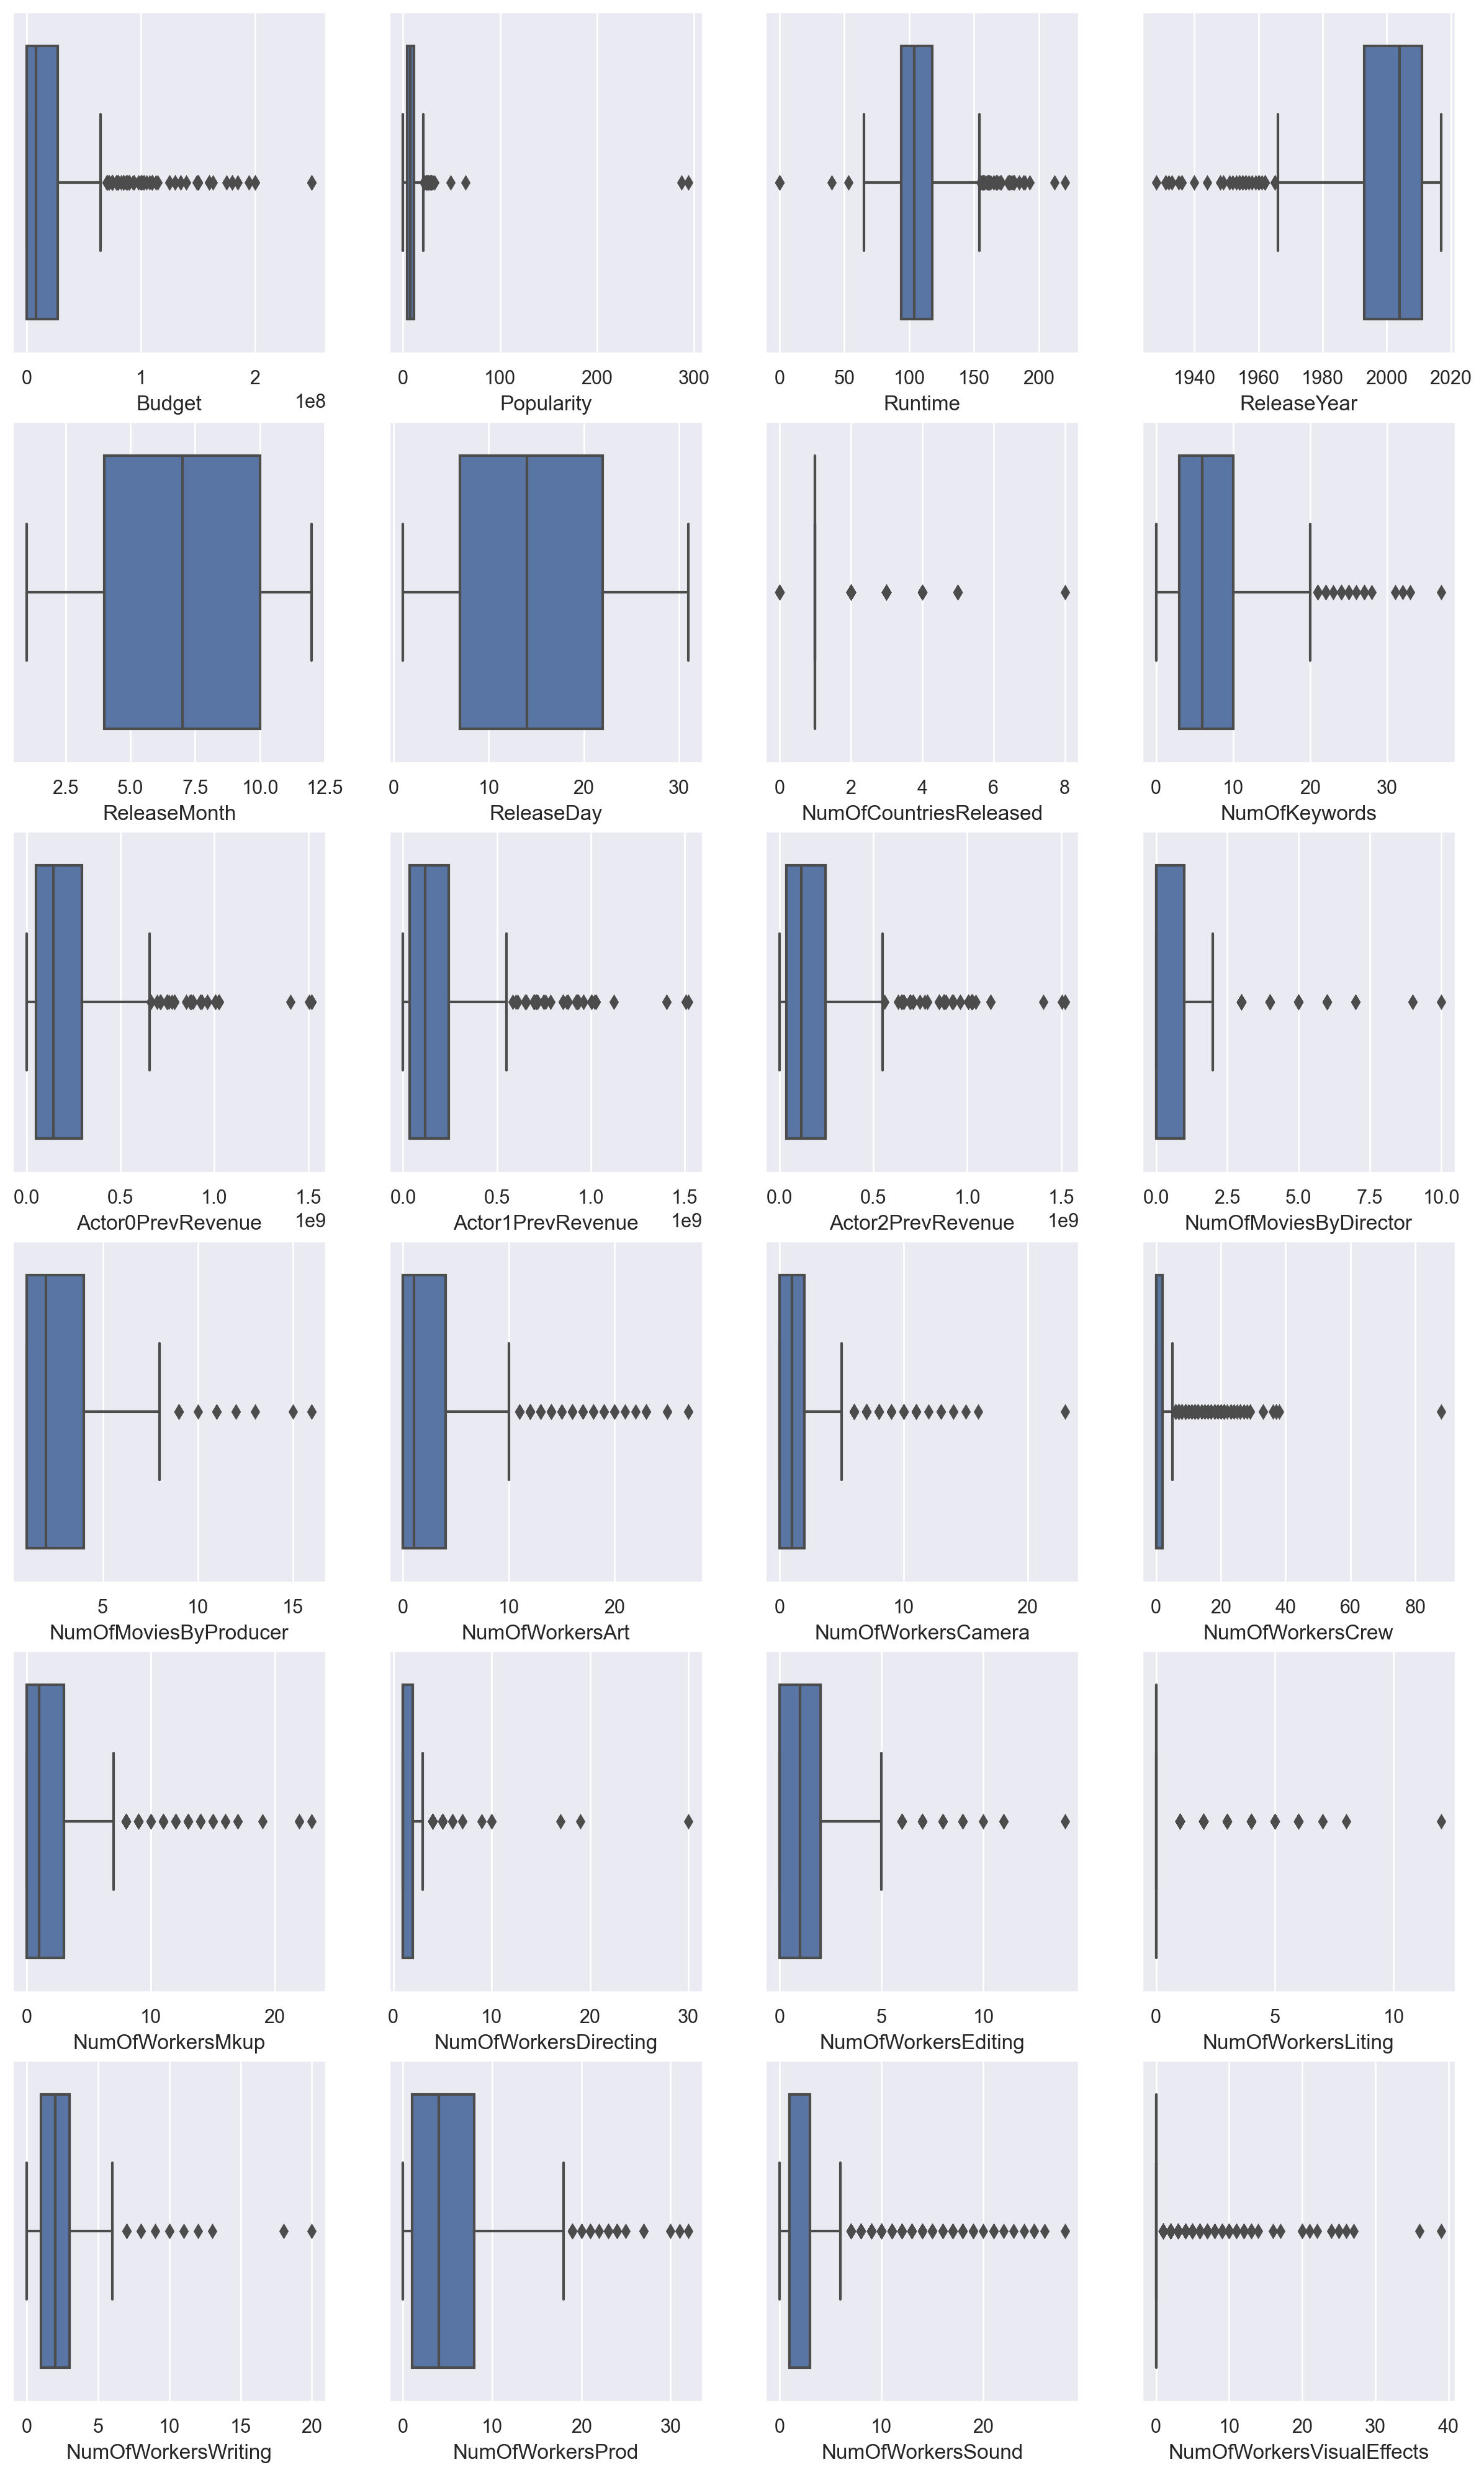

In [210]:
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 25))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.boxplot(data=df[numeric_columns], x=col, ax=axis)
plt.show()

We can see that almost in every feature we have outliers. lets remove them and see the impact on the distribution of the data..

Now we can use scatterplot to visualize x ~ y graphs where y is the target feature.
Later we remove outliers and see the change in those graphs

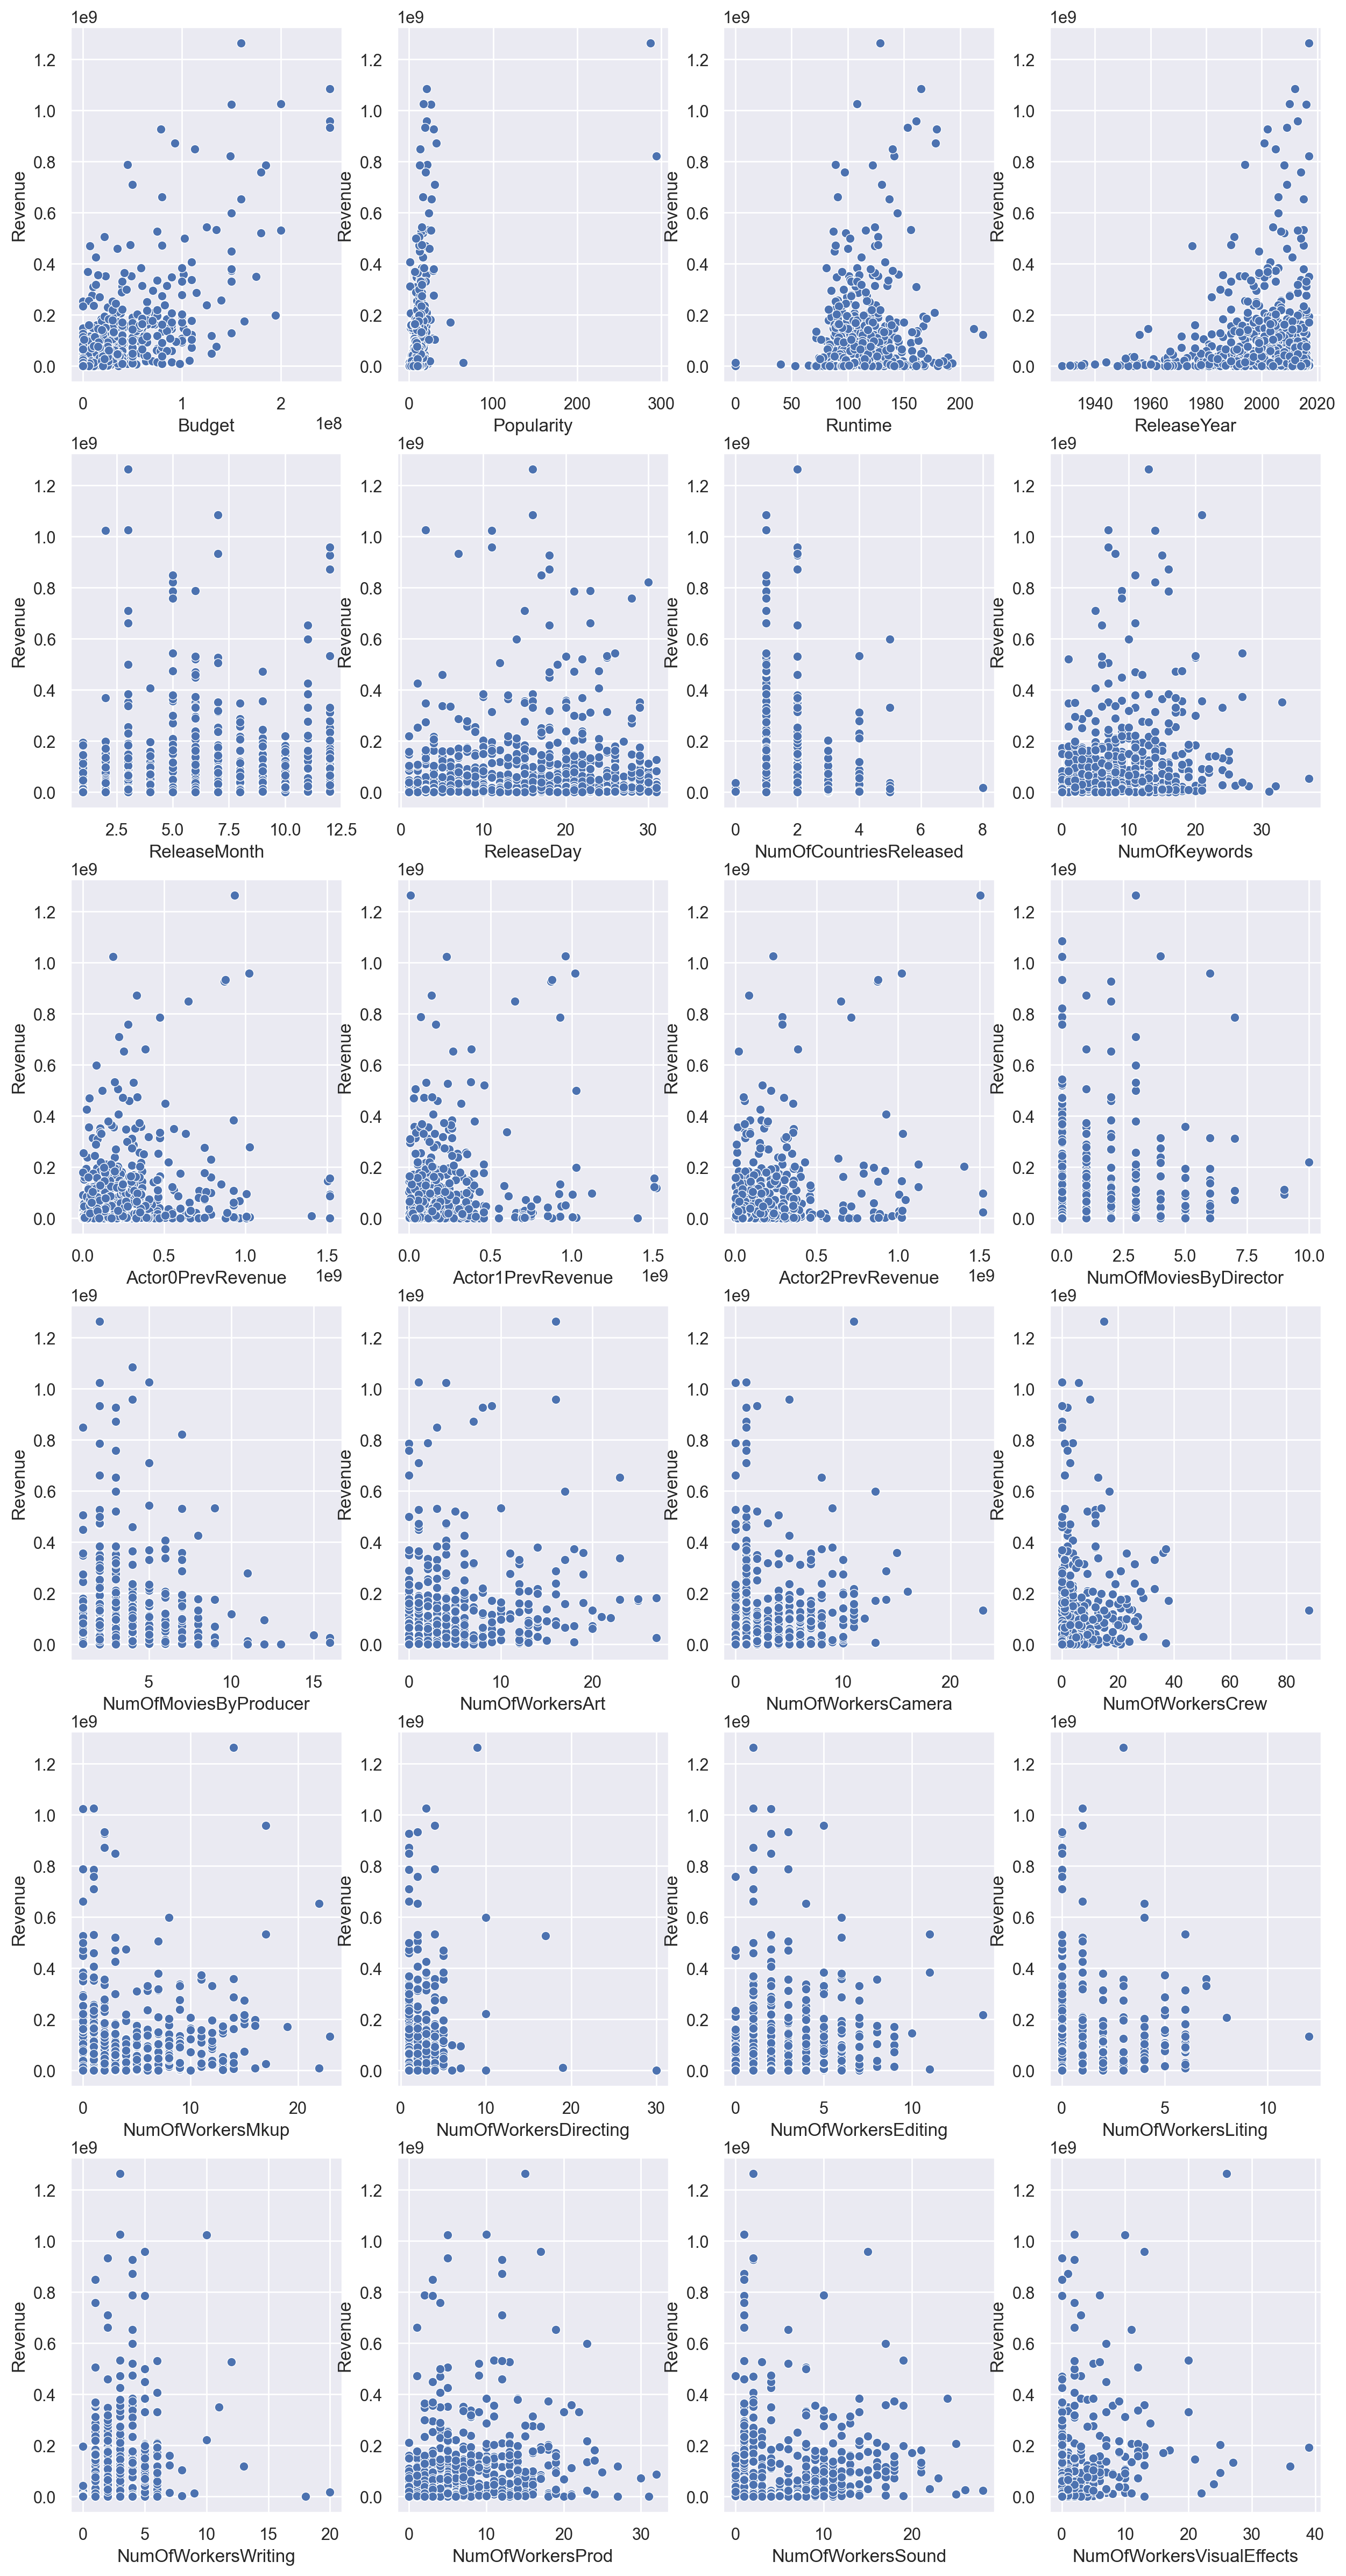

In [211]:
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier
for col, axis in zip(numeric_columns, axes):
    sns.scatterplot(data=df[numeric_columns], x=col, y='Revenue', ax=axis)

Search for the outliers using IQR method

In [212]:
# Set up the matplotlib figure
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
for feature in IQR.index:
    # This features we don't want to remove outliers from
    if str(feature) in ['Budget', 'ReleaseYear', 'ReleaseDay', 'ReleaseMonth']:
        continue
    df = df[~((df[feature] < (Q1[feature] - 1.5 * IQR[feature])) |( df[feature] > (Q3[feature] + 1.5 * IQR[feature])))]
df.shape

    

(398, 42)

We can remove rows we have outliers in:

In [213]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, axis in zip(numeric_columns, axes):
    sns.histplot(data=df[numeric_columns], x=col, ax=axis, kde=True, stat='density')
plt.show()


In [215]:
# Plot x~y where y is the target
fig, axes = plt.subplots(nrows=len(numeric_columns) // 4, ncols=4, figsize=(15, 30))
axes = axes.ravel()  # flattening the array makes indexing easier
for col, axis in zip(numeric_columns, axes):
    sns.scatterplot(data=df[numeric_columns], x=col, y='Revenue', ax=axis)

After removing the outliers three features can be removed from the df as they all have same value. The features we shall remove are - NumOfWorkersVisualEffects, NumOfWorkersLiting,
NumOfCountrysReleased